<h1 align=center><font size = 5>Starting a Restaurant in London, UK</font></h1>

## Introduction

We have been approached by a company interested in investing in a new restaurant opening within London. They have asked us to determine where would be the best location and what sort of restaurant would be most appropriate for that area. The business problem and purpose of this project therefore is to select a borough in London to open a new restaurant and select its cuisine. In order to optimise the location and restaurant type we will characterise the boroughs of London using k-means clustering. The people interested in our results will be those looking to invest in restaurant within London.

1. **Acquire Borough Data** <br />The first part of the project will involve finding data relating to the the borough of London and their location.

2. **Data Wrangling** <br />Using data wrangling techniques this data will be processed and we will keep and collate releveant parameters assocaited with each borough.

3. **Acquire Venue Data (Foursquare API)** <br />We will then use the Foursquare API to get information about the venues within a 1km radius of the borough coordinates. A 1km radius is chosen as it is assumed that this is a suitable walking distance.

4. **Clustering by Restaurant Population** <br />Using k-means clustering we will cluster the boroughs based on the number of resturants per population density into low, medium and high. We opted to use populaion density rather than population as it was assumed that each borough location would only serve a subpopulation with the borough rather than the entire population. Since we are only searching within a 1km vicinty of a location in each borough this helps account for variations in the area of each borough. For the analysis we assume that the boroughs with a relativley high number of resturants (relative to the population density) have features in common. Relevant features could include a disposiable income, business vs residential areas etc. We further assume that these predictive features correlate with features such as the frequency of other types of venue categories (i.e venue categories excluding resturants).

5. **Clustering by Venue Categories** <br />Using k-means clustering we will then cluster the boroughs based on the frequency of types of venues excluding resturants. WE will use the Silhouette Score to select the most appropriate number of clusters. The generated clusters will be refered to hereafter as "feature clusters". If we find a feature cluster which contains many of the relativley high resturant boroughs then we assume that those features are predictive of the type of boroughs which should have a relativley high number of successful resturants.

6. **Borough Selection** <br />We will then see what other boroughs are contained within the same cluster as many of the high resturant boroughs and then select the borough with the relativley lowest number of resturants. The assumption here is that a borough with a relative low number of resturants but features which are shared with the high resturant borough is a good candidate for a new resurant. The best case scenario would be if there are boroughs which appear simultaneously in the low number of resturant cluster and in the feature cluster with a high number of high resturant boroughs.

7. **Resturant Selection** <br />After selecting the best borough for a resurant we will then analyis the best type of resturant to open in that area. For this part of the project we estimate the number of different restruants categories you would expect in the selected borough based on the proportions of different resturant categoeries in the high restrurant cluster. Using this comparision we will decide which type of resturant will have the highest demand in the chosen borough.

8. **Conclusions**

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Acquire Borough Data</a>

2. <a href="#item2">Data Wrangling</a>

3. <a href="#item3">Acquire Venue Data (Foursquare API)</a>

4. <a href="#item4">Clustering by Restaurant Population</a>

5. <a href="#item5">Clustering by Venue Categories</a>    

6. <a href="#item6">Borough Selection</a> 

7. <a href="#item7">Resturant Selection</a> 

8. <a href="#item7">Conclusions</a> 
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [839]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
cols = np.array(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080'])

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Aquire Borough Data

For the borough data we are scraping the webpage: https://en.wikipedia.org/wiki/List_of_London_boroughs

In [335]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_London_boroughs')[0]

Let's take a quick look at the data.

In [336]:
df.head(2)

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31


## 2. Data Wrangling

We can start processing the data for later analysis:

In [338]:
# Extract relevant coloumns
df = df[["Borough", "Population (2013 est)[1]", "Area (sq mi)","Co-ordinates"]]
# Calculate the population density
df["Population (2013 est)[1]"] = (df["Population (2013 est)[1]"]/df["Area (sq mi)"]).round()
df = df.rename(columns={"Population (2013 est)[1]": "Population Density (sq mi)"})
# Drop redundant axis
df = df.drop(["Area (sq mi)"],axis=1)
df.head(2)

,Borough,Population Density (sq mi),Co-ordinates
0,Barking and Dagenham [note 1],13952.0,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E
1,Barnet,11021.0,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W


In [340]:
# Extract Longitude and Latitude from co-ordinates
df["Latitude"]=df["Co-ordinates"].str[-18:-11].astype(float)
df["Longitude"]=df["Co-ordinates"].str[-8:-2].astype(float)
df["East_West"] = df["Co-ordinates"].str[-1]
df = df.drop(["Co-ordinates"],axis=1)
df.head(2)

,Borough,Population Density (sq mi),Latitude,Longitude,East_West
0,Barking and Dagenham [note 1],13952.0,51.5607,0.1557,E
1,Barnet,11021.0,51.6252,0.1517,W


In [341]:
# Multiply the longitude by 1 or -1 if the longitdue is East or West
df["East_West"] = df["East_West"].str.replace("E","1")
df["East_West"] = df["East_West"].str.replace("W","-1").astype(int)
df.Longitude = df.Longitude*df.East_West
df = df.drop(["East_West"],axis=1)
df.head(2)

,Borough,Population Density (sq mi),Latitude,Longitude
0,Barking and Dagenham [note 1],13952.0,51.5607,0.1557
1,Barnet,11021.0,51.6252,-0.1517


In [342]:
# remove the string "[notes x]" from Boroughs
df.Borough = df.Borough.str.replace("\s\Wnote\s\d\W",'')
df_Boroughs = df.Borough
df.head(2)

,Borough,Population Density (sq mi),Latitude,Longitude
0,Barking and Dagenham,13952.0,51.5607,0.1557
1,Barnet,11021.0,51.6252,-0.1517


#### Use geopy library to get the latitude and longitude values of London.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>Lon_explorer</em>, as shown below.

In [343]:
address = 'London, UK'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


#### Create a map of London with boroughs superimposed on top.

In [344]:
df = df.set_index("Borough")

In [545]:
# manual modifications to some borough coordinates to be at town centre
df.at["Barnet","Latitude"] = 51.5861
df.at["Barnet","Longitude"] = -0.2307
df.at["Barking and Dagenham","Latitude"] = 51.5389
df.at["Barking and Dagenham","Longitude"] = 0.1474

In [1310]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df_Boroughs):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

## 3. Aquire Venue Data (Foursquare API)

#### Define Foursquare Credentials and Version

In [547]:
CLIENT_ID = 'FT1GRNDTS2PMIVIHVJJ1J3QUMRTQ5140BPQJAQ5S0AWE4AZK' # your Foursquare ID
CLIENT_SECRET = '420DMR2FMLHN2K4AIQ02BTWDRTOUO10INWPKZYWSOJFRLG4E' # your Foursquare Secret
VERSION = '20200101'

#### Let's explore the first neighborhood in our dataframe.

First, let's create the GET request URL.

In [548]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, latitude, longitude in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [549]:
LIMIT = 100
radius = 1000
London_venues = getNearbyVenues(names=df_Boroughs,
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'],radius=radius)

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [1313]:
print("The number of boroughs we found venues for is:", len(London_venues.Borough.unique()))

The number of boroughs we found venues for is: 32


**One hot the variable categories for clustering**

In [552]:
venue_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="").reset_index(drop = True)

In [553]:
venue_onehot.insert(loc=0, column='Borough', value=London_venues['Borough'] )

In [554]:
Borough_venues_count = venue_onehot.groupby('Borough').sum().reset_index()
Borough_venues_count.head()

,Borough,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Chaat Place,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Palace,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Photography Studio,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Restaurant,River,Rock Club,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Scottish Restaurant,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Smoothie Shop,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Student Center,Supermarket,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track Stadium,Trail,Train Station,Tram Station,Tree,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0

In [709]:
#Borough_venues_count.sum(axis=1)

In [882]:
Restaurant_count = Borough_venues_count[Borough_venues_count.filter(like='Restaurant').columns].sum(axis = 1)
Restaurant_count = pd.DataFrame(Restaurant_count, columns = ['Restaurant Count'])
Restaurant_count.insert(loc=0, column='Borough', value=Borough_venues_count["Borough"])

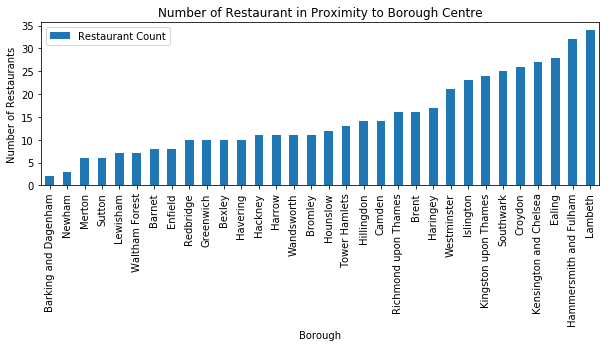

In [883]:
Restaurant_count.sort_values("Restaurant Count").set_index("Borough").plot(kind='bar', figsize=(10,3))
plt.ylabel('Number of Restaurants')
plt.title('Number of Restaurant in Proximity to Borough Centre')
plt.show()

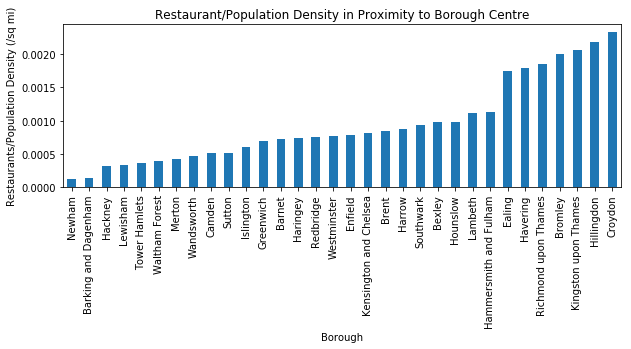

In [884]:
Restaurant_Density = ((Restaurant_count.set_index("Borough")["Restaurant Count"]/df["Population Density (sq mi)"]))
Restaurant_Density.sort_values().plot(kind='bar', figsize=(10,3))
plt.ylabel('Restaurants/Population Density (/sq mi)')
plt.title('Restaurant/Population Density in Proximity to Borough Centre')
plt.show()

In [885]:
df_Restaurant_Density = pd.DataFrame(Restaurant_Density, columns=['Restaurant_Density'])

## 4. Clustering by Resturant Population

In [886]:
kmeans = KMeans(n_clusters=3, random_state=10).fit(np.array((df_Restaurant_Density['Restaurant_Density'])).reshape(-1, 1))
Restaurant_Density_cluster = df_Restaurant_Density
Restaurant_Density_cluster.insert(1, 'Cluster Labels', kmeans.labels_)
#Restaurant_Density_cluster.sort_values("Restaurant_Density")

In [887]:
Restaurant_Density_cluster_sorted = Restaurant_Density_cluster.sort_values("Restaurant_Density")

In [1329]:
high_cluster = Restaurant_Density_cluster_sorted["Cluster Labels"][-1]
low_cluster = Restaurant_Density_cluster_sorted["Cluster Labels"][0]
#since we are using three clusters we can calculate the medium cluster index with 3-(high_cluster+low_cluster)
mid_cluster = 3-(high_cluster+low_cluster)
cluster_labels = [0, 0, 0]
cluster_labels[low_cluster] = 'Low'
cluster_labels[mid_cluster] = 'Medium'
cluster_labels[high_cluster] = 'High'

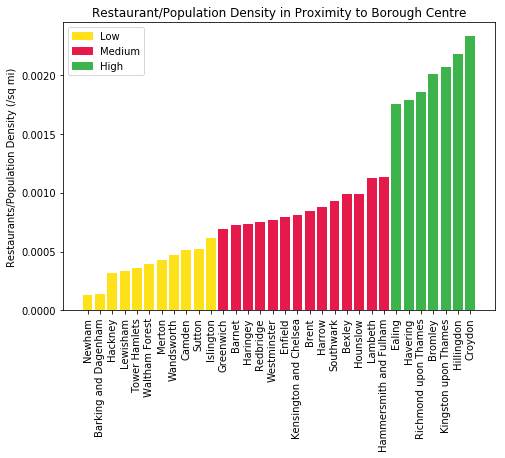

In [1347]:
#Restaurant_Density_cluster_sorted.index
#plt.bar(Restaurant_Density_cluster_sorted.index, Restaurant_Density_cluster_sorted["Restaurant_Density"],
#        color = cols[np.array(Restaurant_Density_cluster_sorted["Cluster Labels"]), ])

plt.bar(Restaurant_Density_cluster_sorted.index, Restaurant_Density_cluster_sorted["Restaurant_Density"],
        color = cols[np.array(Restaurant_Density_cluster_sorted["Cluster Labels"]), ])

plt.xticks(rotation=90)
plt.ylabel('Restaurants/Population Density (/sq mi)')
plt.title('Restaurant/Population Density in Proximity to Borough Centre')
colors = {'Low':cols[low_cluster], 'Medium':cols[mid_cluster], 'High':cols[high_cluster]}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

plt.legend(handles, labels)
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plt.show()

In [1331]:
Restaurant_Density_cluster_merged = df.join(Restaurant_Density_cluster).reset_index()
Restaurant_Density_cluster_merged.head()

,Borough,Population Density (sq mi),Latitude,Longitude,Restaurant_Density,Cluster Labels
0,Barking and Dagenham,13952.0,51.5389,0.1474,0.000143,2
1,Barnet,11021.0,51.5861,-0.2307,0.000726,0
2,Bexley,10123.0,51.4549,0.1505,0.000988,0
3,Brent,18998.0,51.5588,-0.2817,0.000842,0
4,Bromley,5484.0,51.4039,0.0198,0.002006,1


**Map with Resurant Clusters**

In [1356]:
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = np.array(['#3cb44b','#ffe119', '#e6194b'])#3cb44b
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Restaurant_Density_cluster_merged['Latitude'], Restaurant_Density_cluster_merged['Longitude'], Restaurant_Density_cluster_merged['Borough'], Restaurant_Density_cluster_merged['Cluster Labels']):
    label = folium.Popup(str(poi)+': ' + cluster_labels[cluster] + ' resturant cluster', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the above map it looks like the most prolific restaurant industry relative to the population density are around the edge of the city. These areas could correspond to the commuter belt and might indicate more disposable income to support restaurants.

In [907]:
high_resturant_boroughs = np.array(Restaurant_Density_cluster_sorted[Restaurant_Density_cluster_sorted["Cluster Labels"] == high_cluster].index)
low_resturant_boroughs = np.array(Restaurant_Density_cluster_sorted[Restaurant_Density_cluster_sorted["Cluster Labels"] == low_cluster].index)
print("Boroughs with a successful resturant industry relative to the population density are: ", ', '.join(high_resturant_boroughs))
print(' ')
print("Boroughs with a a low resturant industry relative to the population density are: ", ', '.join(low_resturant_boroughs))

Boroughs with a successful resturant industry relative to the population density are:  Ealing, Havering, Richmond upon Thames, Bromley, Kingston upon Thames, Hillingdon, Croydon
 
Boroughs with a a low resturant industry relative to the population density are:  Newham, Barking and Dagenham, Hackney, Lewisham, Tower Hamlets, Waltham Forest, Merton, Wandsworth, Camden, Sutton, Islington


## 5. Clustering by Venue Categories

To investigate features consistent with high restaurant boroughs we *exclude* restaurant venues from the data frame:

In [695]:
#Borough_venues_freq wo resutrant

London_venues_ex = London_venues[~London_venues["Venue Category"].str.contains("Restaurant")].set_index("Borough")
venue_onehot_ex = pd.get_dummies(London_venues_ex[['Venue Category']], prefix="", prefix_sep="")
venue_onehot_ex.reset_index()
venue_onehot_ex.head()

Borough_venues_freq_ex = venue_onehot_ex.groupby('Borough').mean().reset_index()
#Borough_venues_freq_ex.sum(axis=1)

In [696]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [697]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Borough_venues_sorted = pd.DataFrame(columns=columns)
Borough_venues_sorted['Borough'] = Borough_venues_freq_ex['Borough']

for ind in np.arange(Borough_venues_freq_ex.shape[0]):
    Borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Borough_venues_freq_ex.iloc[ind, :], num_top_venues)

**Define a function to calculate the silhouette score and determine the optimal number of clusters to use.**

In [917]:
# set number of clusters
best_silhouette, best_k = -1, 0
silhouette_store = []
k_store = []
Borough_venues_freq_ex_clustering = Borough_venues_freq_ex.drop('Borough', 1)
for kclusters in range(2,32):

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=10).fit(Borough_venues_freq_ex_clustering)
    class_predictions = kmeans.predict(Borough_venues_freq_ex_clustering)
    curr_silhouette = silhouette_score(Borough_venues_freq_ex_clustering, class_predictions)
    silhouette_store.append(curr_silhouette)
    k_store.append(kclusters)
    if curr_silhouette > best_silhouette:
        best_k = kclusters
        best_silhouette = curr_silhouette

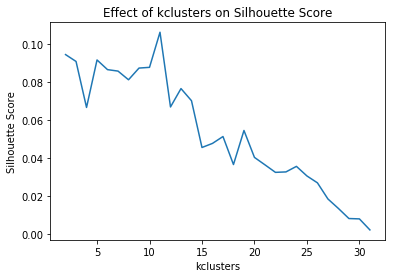

Highest Silhouette Score for K=11


In [918]:
plt.plot(k_store,silhouette_store)
plt.ylabel('Silhouette Score')
plt.xlabel('kclusters')
plt.title('Effect of kclusters on Silhouette Score')
plt.show()
# check cluster labels generated for each row in the dataframe
print('Highest Silhouette Score for', f'K={best_k}')

kmeans = KMeans(n_clusters=best_k, random_state=10).fit(Borough_venues_freq_ex_clustering)

In [700]:
# add clustering labels
Borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#merge initial data frame and data from feature clustering
London_merged = df
London_merged = London_merged.join(Borough_venues_sorted.set_index('Borough'), on='Borough')

In [701]:
London_merged.head()

,Population Density (sq mi),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,,,,,
Barking and Dagenham,13952.0,51.5389,0.1474,6,Pub,Grocery Store,Supermarket,Park,Bus Stop,Bowling Alley,Furniture / Home Store,Bank,Convenience Store,Warehouse Store
Barnet,11021.0,51.5861,-0.2307,7,Grocery Store,Coffee Shop,Pizza Place,Gym / Fitness Center,Bus Stop,Pub,Costume Shop,Park,Café,Student Center
Bexley,10123.0,51.4549,0.1505,1,Pub,Clothing Store,Coffee Shop,Supermarket,Hotel,Pharmacy,Furniture / Home Store,Nightclub,Discount Store,Department Store
Brent,18998.0,51.5588,-0.2817,2,Coffee Shop,Hotel,Bar,Clothing Store,Sporting Goods Shop,Sandwich Place,Grocery Store,Warehouse Store,Pizza Place,Shoe Store
Bromley,5484.0,51.4039,0.0198,1,Pub,Clothing Store,Coffee Shop,Gym / Fitness Center,Supermarket,Electronics Store,Pizza Place,Burger Joint,Café,Stationery Store


**Map with feature clusters**

In [1336]:
Feature_clusters_London_merged = London_merged.reset_index()
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(best_k)
ys = [i + x + (i*x)**2 for i in range(best_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Feature_clusters_London_merged['Latitude'], Feature_clusters_London_merged['Longitude'], Feature_clusters_London_merged['Borough'], Feature_clusters_London_merged['Cluster Labels']):
    label = folium.Popup(str(poi)+': Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the above map it looks like, with the expectation of Richmond upon Thames Cluster 1 captures the perimeter (possibly the commuter belt) of London. We can analyis the feature clusters in more detail below:

**Cluster 0 looks like a trendy area with pubs and speaclist venues such as cocktail bars and bakeries**

In [702]:
London_merged.loc[London_merged['Cluster Labels'] == 0, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Lambeth,Coffee Shop,Pub,Pizza Place,Cocktail Bar,Beer Bar,Market,Yoga Studio,Cupcake Shop,Burger Joint,Café
Southwark,Coffee Shop,Pub,Beer Bar,Garden,Park,Scenic Lookout,Bakery,Brewery,Hotel,Street Food Gathering


**It looks like the boroughs in Cluster 1 share a very frequency of pubs, coffee shops, clothing stores and cafes:**

In [703]:
London_merged.loc[London_merged['Cluster Labels'] == 1, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Bexley,Pub,Clothing Store,Coffee Shop,Supermarket,Hotel,Pharmacy,Furniture / Home Store,Nightclub,Discount Store,Department Store
Bromley,Pub,Clothing Store,Coffee Shop,Gym / Fitness Center,Supermarket,Electronics Store,Pizza Place,Burger Joint,Café,Stationery Store
Croydon,Coffee Shop,Pub,Hotel,Clothing Store,Bookstore,Café,Sandwich Place,Platform,Gym / Fitness Center,Park
Ealing,Coffee Shop,Pub,Pizza Place,Bakery,Park,Burger Joint,Hotel,Café,Gym / Fitness Center,Supermarket
Enfield,Pub,Clothing Store,Coffee Shop,Grocery Store,Supermarket,Optical Shop,Shopping Mall,Gift Shop,Pharmacy,Café
Havering,Coffee Shop,Pub,Clothing Store,Shopping Mall,Park,Furniture / Home Store,Café,Supermarket,Grocery Store,Department Store
Hillingdon,Coffee Shop,Pub,Clothing Store,Pharmacy,Gym,Supermarket,Bar,Burger Joint,Bookstore,Park
Kingston upon Thames,Coffee Shop,Pub,Café,Burger Joint,Park,Clothing Store,Department Store,Hotel,Bookstore,Bar
Sutton,Coffee Shop,Clothing Store,Pub,Café,Hotel,Bar,Sandwich Place,Department Store,Pizza Place,Supermarket


**Boroughs in cluster 2 have a high frequency of hotels:**

In [704]:
London_merged.loc[London_merged['Cluster Labels'] == 2, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Brent,Coffee Shop,Hotel,Bar,Clothing Store,Sporting Goods Shop,Sandwich Place,Grocery Store,Warehouse Store,Pizza Place,Shoe Store
Camden,Coffee Shop,Hotel,Bookstore,Burger Joint,Café,History Museum,Breakfast Spot,Art Gallery,Pizza Place,Park
Tower Hamlets,Park,Coffee Shop,Hotel,Sandwich Place,Lounge,Steakhouse,Hotel Bar,Bus Stop,Gym / Fitness Center,Café
Westminster,Hotel,Coffee Shop,Café,Sandwich Place,Theater,Historic Site,Park,Hotel Bar,Garden,Juice Bar


**Cluster 3 contains bourughs with a high frequency of grocery stores, pubs are less frequent than in otherwise comparable clusters.**

In [652]:
London_merged.loc[London_merged['Cluster Labels'] == 3, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Greenwich,Grocery Store,Pub,Supermarket,Plaza,Coffee Shop,Clothing Store,Hotel,Bakery,Sandwich Place,Pharmacy
Hounslow,Coffee Shop,Clothing Store,Hotel,Grocery Store,Bus Stop,Supermarket,Gift Shop,Pub,Bakery,Sandwich Place
Lewisham,Coffee Shop,Grocery Store,Supermarket,Park,Pub,Hardware Store,Furniture / Home Store,Platform,Pharmacy,Sandwich Place
Redbridge,Grocery Store,Coffee Shop,Supermarket,Clothing Store,Gym / Fitness Center,Pub,Department Store,Sandwich Place,Bakery,Theater


**Similar to cluster 1 with high frequencies of pubs and coffee shops but not as high frequney of clothing stores:**

In [653]:
London_merged.loc[London_merged['Cluster Labels'] == 4, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Hackney,Pub,Coffee Shop,Bakery,Brewery,Café,Park,Supermarket,Flea Market,Beer Store,Wine Shop
Hammersmith and Fulham,Pub,Coffee Shop,Café,Gym / Fitness Center,Park,Sandwich Place,Gastropub,Plaza,Clothing Store,Bar
Islington,Pub,Coffee Shop,Park,Café,Gastropub,Boutique,Bakery,Trail,Cocktail Bar,Theater
Richmond upon Thames,Pub,Coffee Shop,Café,Grocery Store,Park,Bakery,Pharmacy,Pizza Place,Deli / Bodega,Boat or Ferry
Waltham Forest,Pub,Café,Art Gallery,Coffee Shop,Gym / Fitness Center,Pizza Place,Brewery,Burger Joint,Park,Multiplex
Wandsworth,Pub,Café,Gym / Fitness Center,Coffee Shop,Hotel,Clothing Store,Pizza Place,Grocery Store,Supermarket,Breakfast Spot


**Cluster 5 is a unique area due to the London City airport, with a high frequency of hotels and airport services.**

In [661]:
London_merged.loc[London_merged['Cluster Labels'] == 5, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Newham,Hotel,Airport Service,Sandwich Place,Airport Lounge,Coffee Shop,Light Rail Station,Farm,Rafting,Pub,Pharmacy


**The remaining clusters have a single bourough and may represent outliers with a high frquency of comparativley unusual venues:**

In [655]:
London_merged.loc[London_merged['Cluster Labels'] == 6, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Barking and Dagenham,Pub,Grocery Store,Supermarket,Park,Bus Stop,Bowling Alley,Furniture / Home Store,Bank,Convenience Store,Warehouse Store


In [656]:
London_merged.loc[London_merged['Cluster Labels'] == 7, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Barnet,Grocery Store,Coffee Shop,Pizza Place,Gym / Fitness Center,Bus Stop,Pub,Costume Shop,Park,Café,Student Center


In [657]:
London_merged.loc[London_merged['Cluster Labels'] == 8, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Merton,Café,Supermarket,Park,Train Station,Pool,Bakery,Coffee Shop,Pet Store,Pub,Sandwich Place


In [658]:
London_merged.loc[London_merged['Cluster Labels'] == 9, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Haringey,Pub,Clothing Store,Café,Bakery,Park,Grocery Store,Sandwich Place,Pharmacy,Hotel Bar,Burger Joint
Kensington and Chelsea,Café,Pub,Bakery,Clothing Store,Garden,Juice Bar,Burger Joint,Hotel,Playground,Supermarket


In [659]:
London_merged.loc[London_merged['Cluster Labels'] == 10, London_merged.columns[[4] + list(range(5, London_merged.shape[1]))]]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Harrow,Coffee Shop,Sandwich Place,Clothing Store,Bus Stop,Park,Pharmacy,Platform,Movie Theater,Department Store,Donut Shop


## 6. Borough Selection

In [1307]:
#For each feature cluster count how many boroughs are also included in the high resturant cluster
num_high_boroughs_in_cluster = []
for curr_k in range(best_k):
    curr_cluster = np.array(London_merged.loc[London_merged['Cluster Labels'] == curr_k].index)
    num_high_boroughs_in_cluster.append(len(np.intersect1d(curr_cluster, high_resturant_boroughs)))
    

In [1308]:
high_resturant_feature_cluster = num_high_boroughs_in_cluster.index(max(num_high_boroughs_in_cluster)) # note will only give first instance of max value.

In [1309]:
print("The feature cluster which has the highest degree of overlap with the high resurant cluster is feature cluster", high_resturant_feature_cluster, " with", max(num_high_boroughs_in_cluster), "of the high resturant clusters")
print(" ")
print("Feature cluster", high_resturant_feature_cluster,"contains", max(num_high_boroughs_in_cluster), "out of the", len(high_resturant_boroughs),"boroughs in the high resturant clusters (=", round(max(num_high_boroughs_in_cluster)/len(high_resturant_boroughs)*100,2), "%)")

if num_high_boroughs_in_cluster.count(max(num_high_boroughs_in_cluster)) != 1:
    print('')
    print("!!----------------------------------------------------------------------------------------!!")
    print("    Warning other feature clusters contain the same number of high resturant clusters")
    print("!!----------------------------------------------------------------------------------------!!")

The feature cluster which has the highest degree of overlap with the high resurant cluster is feature cluster 1  with 6 of the high resturant clusters
 
Feature cluster 1 contains 6 out of the 7 boroughs in the high resturant clusters (= 85.71 %)


In [967]:
Boroughs_in_high_resturant_feature_cluster = np.array((London_merged[London_merged["Cluster Labels"] == high_resturant_feature_cluster]).index)

In [968]:
print("Boroughs in the high restaurants feature cluster: ", ', '.join(Boroughs_in_high_resturant_feature_cluster))
print(' ')
print("Boroughs with a low restaurants industry relative to the population density are: ", ', '.join(low_resturant_boroughs))

Boroughs in the high resturant feature cluster:  Bexley, Bromley, Croydon, Ealing, Enfield, Havering, Hillingdon, Kingston upon Thames, Sutton
 
Boroughs with a a low resturant industry relative to the population density are:  Newham, Barking and Dagenham, Hackney, Lewisham, Tower Hamlets, Waltham Forest, Merton, Wandsworth, Camden, Sutton, Islington


We can then look for overlap between the two clusters and select the borough with the relatively lowest number of resturants:

In [1194]:
best_features_low_resturants = np.intersect1d(Boroughs_in_high_resturant_feature_cluster, low_resturant_boroughs)
#best_features_low_resturants = np.append(best_features_low_resturants,"Newham")
if len(best_features_low_resturants) == 0:
    print("There were no bouroughs with a low restaurant presence in the promising feature group")
else:
    print("The boroughs with features consistent with a successful restaurant industry but a low restaurant presence are:", ', '.join(best_features_low_resturants))
    print("")
    df_best_features_low_resturants = Restaurant_Density_cluster_sorted["Restaurant_Density"].loc[best_features_low_resturants]
    min_Restaurant_Density = df_best_features_low_resturants.min()
    best_borough = df_best_features_low_resturants[df_best_features_low_resturants==min_Restaurant_Density].index
    best_borough = "".join(best_borough) # is there a better way to convert index to string?
    print("Of the above boroughs the one with the lowest restaurant  per population density is:", best_borough)
    

The boroughs with features consistent with a successful resturant industry but a low resturant presence are: Sutton

Of the above boroughs the one with the lowest resturants per population density is: Sutton


## 7. Resturant Selection

In [1071]:
Restaurant_Density_cluster_sorted[Restaurant_Density_cluster_sorted["Cluster Labels"] == high_cluster]

,Restaurant_Density,Cluster Labels
Borough,,
Ealing,0.001753,1
Havering,0.001791,1
Richmond upon Thames,0.001854,1
Bromley,0.002006,1
Kingston upon Thames,0.002069,1
Hillingdon,0.002180,1
Croydon,0.002330,1


In [1217]:
venue_dataframe = Borough_venues_count.set_index("Borough")
restaurant_dataframe = venue_dataframe[venue_dataframe.filter(like='Restaurant').columns]

In [1222]:
high_restaurant_dataframe_pc = pd.DataFrame(restaurant_dataframe.loc[high_resturant_boroughs].sum(), columns = ["Percentage"])


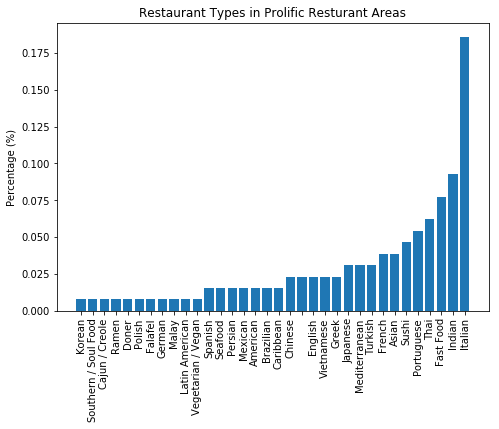

In [1224]:
high_restaurant_pc = ((high_restaurant_dataframe_pc[(high_restaurant_dataframe_pc.T != 0).all()])/high_restaurant_dataframe_pc.sum()).sort_values("Percentage")


plt.bar(high_restaurant_pc.index.str[:-11], high_restaurant_pc["Percentage"]) #only use prefix resturant as xlabel [:-11]
plt.xticks(rotation=90)
plt.ylabel('Percentage (%)')
plt.title('Restaurant Types in Prolific Resturant Areas')

plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plt.show()

If we assume that the high restaurant boroughs collectively indicate the viable restaurants categories and their frequency then we can normalise the total number of each restaurants with respect to the total population density of these boroughs.

In [1277]:
Total_pop_den = df.loc[high_resturant_boroughs]["Population Density (sq mi)"].sum()
high_restaurant_dataframe_ppd = pd.DataFrame(restaurant_dataframe.loc[high_resturant_boroughs].sum(), columns = ["/pop_den"])
high_restaurant_ppd = ((high_restaurant_dataframe_ppd[(high_restaurant_dataframe_ppd.T != 0).all()])/Total_pop_den).sort_values("/pop_den")
high_restaurant_ppd.head()

,/pop_den
Korean Restaurant,0.000015
Southern / Soul Food Restaurant,0.000015
Cajun / Creole Restaurant,0.000015
Ramen Restaurant,0.000015
Doner Restaurant,0.000015


If we multiply the high_restaurant count per population density by population density of our selected borough then we get an indication of the numbers of restruants that the borough could accomodate:

In [1287]:
expect_num_restaurant_in_selected = (high_restaurant_ppd*pop_den).apply(np.floor)
expect_num_restaurant_in_selected = expect_num_restaurant_in_selected[(expect_num_restaurant_in_selected.T != 0).all()].rename(columns={"/pop_den": "Expected number"})
expect_num_restaurant_in_selected

,Expected number
Sushi Restaurant,1.0
Portuguese Restaurant,1.0
Thai Restaurant,1.0
Fast Food Restaurant,1.0
Indian Restaurant,2.0
Italian Restaurant,4.0


We can compare this with the number in our selected borough and see which resturants would be in highest demand:

In [1296]:
best_restaurant_dataframe = pd.DataFrame(restaurant_dataframe.loc[best_borough])
pop_den = df.loc[best_borough]["Population Density (sq mi)"]
best_restaurant_dataframe_ppd = best_restaurant_dataframe.rename(columns={best_borough: "/pop_den"})
best_resaurant_ppd = ((best_restaurant_dataframe_ppd[(best_restaurant_dataframe_ppd.T != 0).all()])/pop_den).sort_values("/pop_den")
num_restaurant_in_selected = (best_resaurant_ppd*pop_den).rename(columns={"/pop_den": "True number"})
num_restaurant_in_selected

,True number
Fast Food Restaurant,1.0
French Restaurant,1.0
Indian Restaurant,1.0
Portuguese Restaurant,1.0
Italian Restaurant,2.0


In [1293]:
combined_expec_and_true = expect_num_restaurant_in_selected.join(num_restaurant_in_selected).fillna(0)
combined_expec_and_true["Difference"] = combined_expec_and_true["Expected number"]-combined_expec_and_true["True number"]
combined_expec_and_true

,Expected number,True number,Difference
Sushi Restaurant,1.0,0.0,1.0
Portuguese Restaurant,1.0,1.0,0.0
Thai Restaurant,1.0,0.0,1.0
Fast Food Restaurant,1.0,1.0,0.0
Indian Restaurant,2.0,1.0,1.0
Italian Restaurant,4.0,2.0,2.0


Based on this analysis good restaurants to consider would be Italian, Indian, Thai or Sushi. We can order these more exactly by considering the difference in the expected number per population density and the true number per population density:

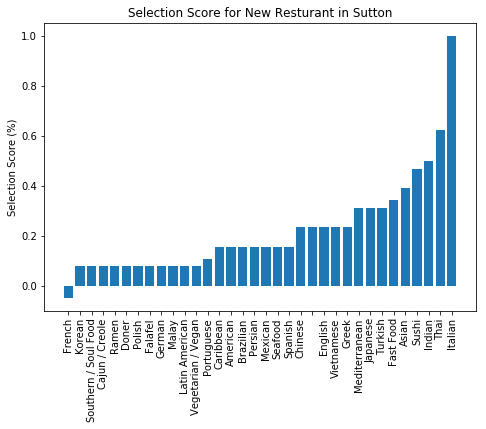

In [1305]:
combined_expec_and_true_ppd = high_restaurant_ppd.join(best_resaurant_ppd, lsuffix = '_expect', rsuffix='_selected').fillna(0)
combined_expec_and_true_ppd["Normalised Difference"] = combined_expec_and_true_ppd["/pop_den_selected"]-combined_expec_and_true_ppd["/pop_den_expect"]
combined_expec_and_true_ppd["Normalised Difference"] = combined_expec_and_true_ppd["Normalised Difference"]/combined_expec_and_true_ppd["Normalised Difference"].min()
combined_expec_and_true_ppd = combined_expec_and_true_ppd.sort_values("Normalised Difference")

plt.bar(combined_expec_and_true_ppd.index.str[:-11], combined_expec_and_true_ppd["Normalised Difference"]) #only use prefix resturant as xlabel [:-11]
plt.xticks(rotation=90)
plt.ylabel('Selection Score (%)')
plt.title('Selection Score for New Resturant in '+best_borough)

plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plt.show()

Based on this analysis the best choice for a new restaurant would be either an Italian or Thai. Based on the high restaurant areas there is likely a high demand for another Italian, despite a presence already in Sutton. We should also seriously consider the possibility of a Thai restaurant which comes second in the above scoring metric and otherwise has no direct competitors in terms of cuisine. This exlusivity might make the choice of Thai promising compared to Italian than the above scoring system implies which consider a fairly saturated marketplace. The question of Italian or Thai could be answered more definatley with additional data which examines the benefit of exlusivity in the restaurant sector.

## 8. Conclusions

Based on the analysis above we identified the most promising borough as Sutton. Sutton shares feature with many of the boroughs which have high population of restaurants relative to the population density, but Sutton has very few restaurants itself given its population density. Sutton was the only low restaurants borough in the feature cluster containing ~85% of the high restaurant boroughs. Having identified Sutton we developed a scoring system to determine the type of restaurants that would be the most successful. Using the data from the boroughs in the high restaurants cluster we estimated what sort of restaurants could be accommodated by Sutton given its population density. Based on this analysis the top two cuisines were Italian followed by Thai. It should be noted however that there are already two Italian restaurants in Sutton, but no Thai. We therefore recommend Thai as based on the available data from similar boroughs will be a high demand for Thai cuisine and there is at present no direct competitor.

Borough: Sutton

Restaurant: Thai

**Thank you for reviewing this project**

**Comments are most welcome**

**Additional Notes**

We might also want to consider whether:
1. Areas might have a low population but a high degree of footfall.
2. The location of boroughs may not be at major towns.
3. Whether a finer granularity at the scale of neighbourhoods would give more reliable results.
